In [113]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn import model_selection
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [114]:
df = pd.read_csv(r"C:\Users\user\Documents\UoM\8th_semester\Neural Neworks\2η εργασία\log2.csv", engine="python")

In [115]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [116]:
df['Action'].value_counts()

allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

In [117]:
print(df['Source Port'].nunique())
print(df['Destination Port'].nunique())
print(df['NAT Source Port'].nunique())
print(df['NAT Destination Port'].nunique())

22724
3273
29152
2533


In [118]:
df = df.drop(columns=['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port'])

In [119]:
df.head()

,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,allow,177,94,83,2,30,1,1
1,allow,4768,1600,3168,19,17,10,9
2,allow,238,118,120,2,1199,1,1
3,allow,3327,1438,1889,15,17,8,7
4,allow,25358,6778,18580,31,16,13,18


In [120]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [121]:
df['target'] = df['Action']
df['target'] = df['target'].astype(str)
df = df.drop(columns=['Action'])

In [122]:
df.head()

,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,target
0,177,94,83,2,30,1,1,allow
1,4768,1600,3168,19,17,10,9,allow
2,238,118,120,2,1199,1,1,allow
3,3327,1438,1889,15,17,8,7,allow
4,25358,6778,18580,31,16,13,18,allow


In [200]:
labelEncoder = LabelEncoder()

df.iloc[:,-1] = labelEncoder.fit_transform(df.iloc[:,-1])

In [201]:
df.dtypes

Bytes                 int64
Bytes Sent            int64
Bytes Received        int64
Packets               int64
Elapsed Time (sec)    int64
pkts_sent             int64
pkts_received         int64
target                int32
dtype: object

In [202]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [203]:
# split data to train, test and validation data
train, test = model_selection.train_test_split(df,test_size=0.2)
train, val = model_selection.train_test_split(train,test_size=0.2)

batch_size = 75 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [204]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  minmaxscaler = MinMaxScaler()
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
    minmaxscaler.fit_transform(feature_ds)
#   normalizer.adapt(feature_ds)
  
  return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_values=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name].astype(str))

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

In [205]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [225]:
x = tf.keras.layers.Dense(128, activation="relu")
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

ValueError: Attempt to convert a value (<tensorflow.python.keras.layers.core.Dense object at 0x000001A4EDF9A4A8>) with an unsupported type (<class 'tensorflow.python.keras.layers.core.Dense'>) to a Tensor.

In [222]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [223]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/100
560/560 [==============================] - 3s 4ms/step - loss: -2.0837 - accuracy: 0.6133 - val_loss: -43.7722 - val_accuracy: 0.6251
Epoch 2/100
560/560 [==============================] - 2s 4ms/step - loss: -87.3173 - accuracy: 0.6192 - val_loss: -337.2188 - val_accuracy: 0.6642
Epoch 3/100
560/560 [==============================] - 2s 4ms/step - loss: -459.0483 - accuracy: 0.6208 - val_loss: -1081.7673 - val_accuracy: 0.6617
Epoch 4/100
560/560 [==============================] - 2s 4ms/step - loss: -1245.2946 - accuracy: 0.6253 - val_loss: -2379.8928 - val_accuracy: 0.6649
Epoch 5/100
560/560 [==============================] - 2s 4ms/step - loss: -2621.1605 - accuracy: 0.6288 - val_loss: -4407.1875 - val_accuracy: 0.6617
Epoch 6/100
560/560 [==============================] - 3s 4ms/step - loss: -4726.7031 - accuracy: 0.6218 - val_loss: -7016.8696 - val_accuracy: 0.6644
Epoch 7/100
560/560 [==============================] - 3s 4ms/step - loss: -7338.2361 - accuracy: 0.627

Epoch 54/100
560/560 [==============================] - 3s 5ms/step - loss: -1589839.8596 - accuracy: 0.6233 - val_loss: -1780601.7500 - val_accuracy: 0.6633
Epoch 55/100
560/560 [==============================] - 3s 5ms/step - loss: -1683723.8803 - accuracy: 0.6236 - val_loss: -1863380.3750 - val_accuracy: 0.6641
Epoch 56/100
560/560 [==============================] - 3s 5ms/step - loss: -1773923.6629 - accuracy: 0.6242 - val_loss: -1955839.0000 - val_accuracy: 0.6641
Epoch 57/100
560/560 [==============================] - 3s 5ms/step - loss: -1850796.1113 - accuracy: 0.6261 - val_loss: -2048720.1250 - val_accuracy: 0.6641
Epoch 58/100
560/560 [==============================] - 3s 5ms/step - loss: -1900766.2507 - accuracy: 0.6272 - val_loss: -2143891.5000 - val_accuracy: 0.6641
Epoch 59/100
560/560 [==============================] - 3s 5ms/step - loss: -2016466.3574 - accuracy: 0.6233 - val_loss: -2245660.5000 - val_accuracy: 0.6641
Epoch 60/100
560/560 [==============================

In [219]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

175/175 [==============================] - 0s 2ms/step - loss: -2300195.5000 - accuracy: 0.6729
Accuracy 0.6729228496551514


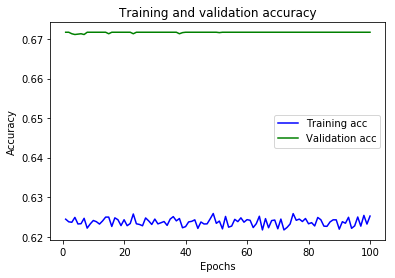

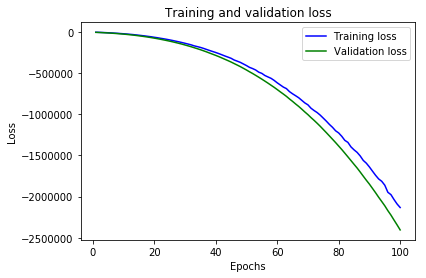

In [220]:
# Plotting Results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()